In [1]:
!pip install -q kaggle --quiet


In [5]:
!cp kaggle.json ~/.kaggle/




In [6]:
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

 99% 610M/616M [00:05<00:00, 152MB/s]
100% 616M/616M [00:05<00:00, 110MB/s]


In [ ]:
!unzip people-clothing-segmentation.zip 


In [8]:
# for path related functionalities
import os
import cv2
# for array operations
import numpy as np
# tensorflow framework
import tensorflow as tf
# keras API for deep learning
from tensorflow import keras
# for image visulaizations
import matplotlib.pyplot as plt
# for legends and other supporting functionalities
import matplotlib as mpl
# for viewing iteration status
from tqdm import tqdm

from sklearn.model_selection import train_test_split


In [9]:
# a list to collect paths of 1000 images
image_path = []
for root, dirs, files in os.walk('/content/png_images'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [10]:
# a list to collect paths of 1000 masks
mask_path = []
for root, dirs, files in os.walk('/content/png_masks'):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

# Sorting the datasets to get the right image-mask pairs

In [11]:
image_path.sort()
mask_path.sort()

# Decoding the images and masks to store them in seperate lists

In [12]:
# create a list to store images
images = []
# iterate over 1000 image paths
for path in tqdm(image_path):
    # read file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    # append to the list
    images.append(image)


# create a list to store masks
masks = []
# iterate over 1000 mask paths
for path in tqdm(mask_path):
    # read the file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    # append mask to the list
    masks.append(mask)

100%|██████████| 1000/1000 [00:02<00:00, 387.56it/s]


In [13]:
# length of images and masks
len(images), len(masks)

(1000, 1000)

# Visualizing a sample of the images and its corresponding mask

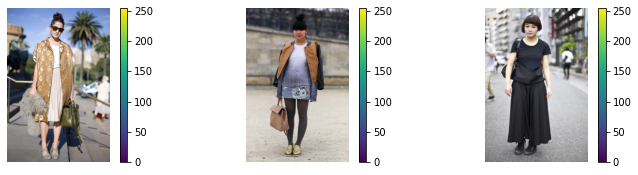

In [14]:
plt.figure(figsize=(25,13))
for i in range(4,7):
    plt.subplot(4,6,i)
    img = images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

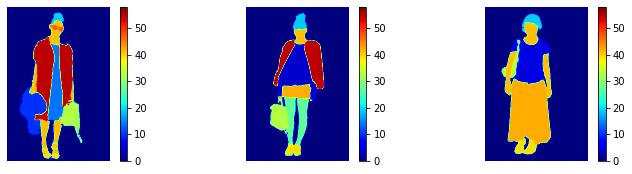

In [15]:
# Define a normalizer that can be applied while visualizing masks to have a consistency
# min class value is 0
# max class value is 58
NORM = mpl.colors.Normalize(vmin=0, vmax=58)

# plot masks
plt.figure(figsize=(25,13))
for i in range(4,7):
    plt.subplot(4,6,i)
    img = masks[i]
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

# Preprocessing

In [16]:
#shape of an example image and mask 
images[0].shape, masks[0].shape

(TensorShape([825, 550, 3]), TensorShape([825, 550, 1]))

In [17]:
#functions to resize the images and masks 
def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [18]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1000, 1000)

In [19]:
#checking the datatypes
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

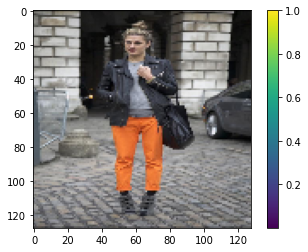

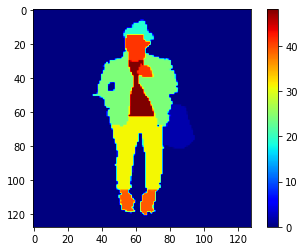

In [20]:
#visualizing a resized image and respective mask
# plot an image
plt.imshow(X[36])
plt.colorbar()
plt.show()

#plot a mask
plt.imshow(y[36], cmap='jet')
plt.colorbar()
plt.show()

# splitting into training and validation 

In [21]:
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )
# develop tf Dataset objects
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

# Data Augmentation
To Increase Training Data

In [22]:
# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# adjust gamma of image
# don't alter in mask
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

# adjust hue of image
# don't alter in mask
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

Perform data augmentation with original training set and concatenate with enlarged training set. Which will give us, with 7 functions, 7*800=5600 plus the original 800, total 6400.

In [23]:
# zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [24]:
#setting the batch size
BATCH = 64

AT = tf.data.AUTOTUNE
#buffersize
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

# Building the Model
We will use FCNN(Fully Convolutional Neural Networks) which contains two parts: an encoder and a decoder. An encoder is a downstack of convolutional neural layers that extract features from the input image. A decoder is an upstack of transpose convolutional neural layers that builds the segmented image from the extracted features.
In this project we will use the U-Net architecture

We wish to use the functional approach of U-Net architecture, but we will have our own architecture suitable to our task. The downstack can be a pre-trained CNN, trained for image classification (e.g. MobileNetV2, ResNet, NASNet, Inception, DenseNet, or EfficientNet). It can effectively extract the features. But, we have to build our upstack to match our classes (here, 59), build skip-connections, and train it with our data.

In [25]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3], 
                                      include_top=False, 
                                      weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [26]:
#length of layers
len(base.layers)

427

In [27]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [28]:
#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [29]:
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

# Building the Upstack

Building the upstack using an upsampling template. Let's use pix2pix template available open-source in tensorflow_examples repository

In [30]:
!pip install -q git+https://github.com/tensorflow/examples.git --quiet

  Preparing metadata (setup.py) ... done
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [31]:
from tensorflow_examples.models.pix2pix import pix2pix

# Four upstack layers for upsampling sizes 
# 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [32]:
upstack[1].layers

# Building the U-Net model with skip connections
Merging the downstack and upstack with skip-connections

In [33]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample 
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])
    
# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

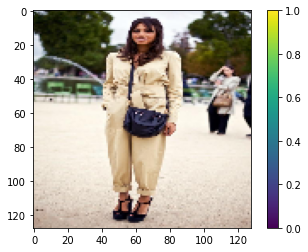

In [34]:
#checking for model and data compatibility
# infer on train dataset
example = next(iter(train))
preds = unet(example[0])

# visualize an image
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

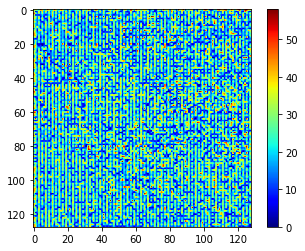

In [35]:
# visualize the predicted mask
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0], cmap='jet', norm=NORM)
plt.colorbar()

In [36]:
# compiling the model 
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy']) 
Compile_Model()

In [37]:
#training and fine-tuning
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=20,
               verbose=2)

Epoch 1/20
12/12 - 240s - loss: 2.9550 - accuracy: 0.5881 - val_loss: 3.6338 - val_accuracy: 0.7429 - 240s/epoch - 20s/step
Epoch 2/20
12/12 - 203s - loss: 1.7752 - accuracy: 0.7632 - val_loss: 3.0846 - val_accuracy: 0.7634 - 203s/epoch - 17s/step
Epoch 3/20
12/12 - 214s - loss: 1.3309 - accuracy: 0.7694 - val_loss: 2.5930 - val_accuracy: 0.7659 - 214s/epoch - 18s/step
Epoch 4/20
12/12 - 213s - loss: 1.3782 - accuracy: 0.7065 - val_loss: 2.2362 - val_accuracy: 0.7687 - 213s/epoch - 18s/step
Epoch 5/20
12/12 - 203s - loss: 1.2699 - accuracy: 0.7101 - val_loss: 1.8774 - val_accuracy: 0.7741 - 203s/epoch - 17s/step
Epoch 6/20
12/12 - 206s - loss: 1.0741 - accuracy: 0.7468 - val_loss: 1.5889 - val_accuracy: 0.7746 - 206s/epoch - 17s/step
Epoch 7/20
12/12 - 201s - loss: 1.0145 - accuracy: 0.7610 - val_loss: 1.3964 - val_accuracy: 0.7751 - 201s/epoch - 17s/step
Epoch 8/20
12/12 - 188s - loss: 0.9643 - accuracy: 0.7691 - val_loss: 1.1829 - val_accuracy: 0.7684 - 188s/epoch - 16s/step
Epoch 9/

<b>Making a Prediction

2/2 [==============================] - 10s 4s/step


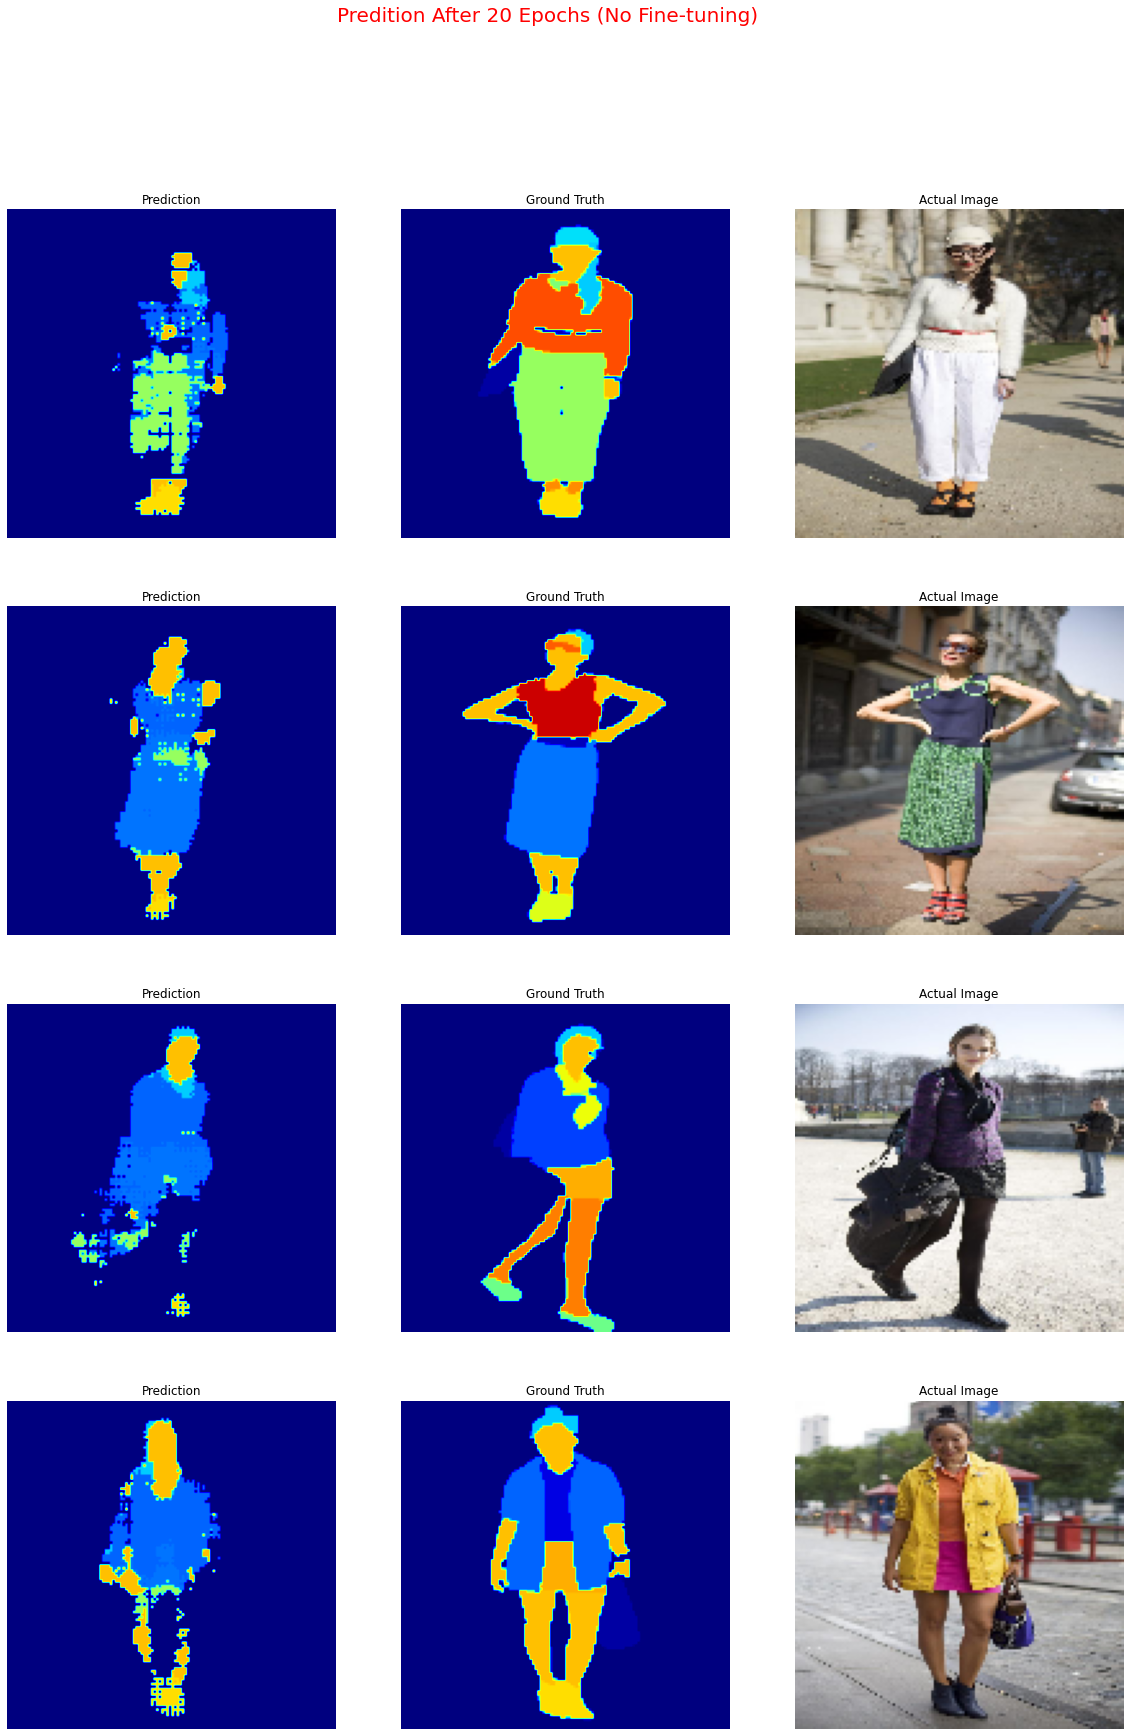

In [38]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')
    
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 20 Epochs (No Fine-tuning)', color='red', size=20)  
plt.show()

In [39]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 20 to 40
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=40, initial_epoch = 20,
               verbose = 2
                 )

Epoch 21/40
12/12 - 390s - loss: 0.6688 - accuracy: 0.8258 - val_loss: 0.7404 - val_accuracy: 0.8110 - 390s/epoch - 32s/step
Epoch 22/40
12/12 - 347s - loss: 0.5994 - accuracy: 0.8428 - val_loss: 0.7440 - val_accuracy: 0.8109 - 347s/epoch - 29s/step
Epoch 23/40
12/12 - 368s - loss: 0.5633 - accuracy: 0.8528 - val_loss: 0.7647 - val_accuracy: 0.8088 - 368s/epoch - 31s/step
Epoch 24/40
12/12 - 370s - loss: 0.8131 - accuracy: 0.7962 - val_loss: 0.7825 - val_accuracy: 0.8074 - 370s/epoch - 31s/step
Epoch 25/40
12/12 - 359s - loss: 0.7682 - accuracy: 0.8031 - val_loss: 0.8451 - val_accuracy: 0.7996 - 359s/epoch - 30s/step
Epoch 26/40
12/12 - 345s - loss: 0.6823 - accuracy: 0.8245 - val_loss: 0.7704 - val_accuracy: 0.8134 - 345s/epoch - 29s/step
Epoch 27/40
12/12 - 330s - loss: 0.6395 - accuracy: 0.8327 - val_loss: 0.9438 - val_accuracy: 0.7900 - 330s/epoch - 28s/step
Epoch 28/40
12/12 - 342s - loss: 0.6138 - accuracy: 0.8412 - val_loss: 0.9512 - val_accuracy: 0.7916 - 342s/epoch - 28s/step


<b>Making a Prediction

2/2 [==============================] - 10s 3s/step


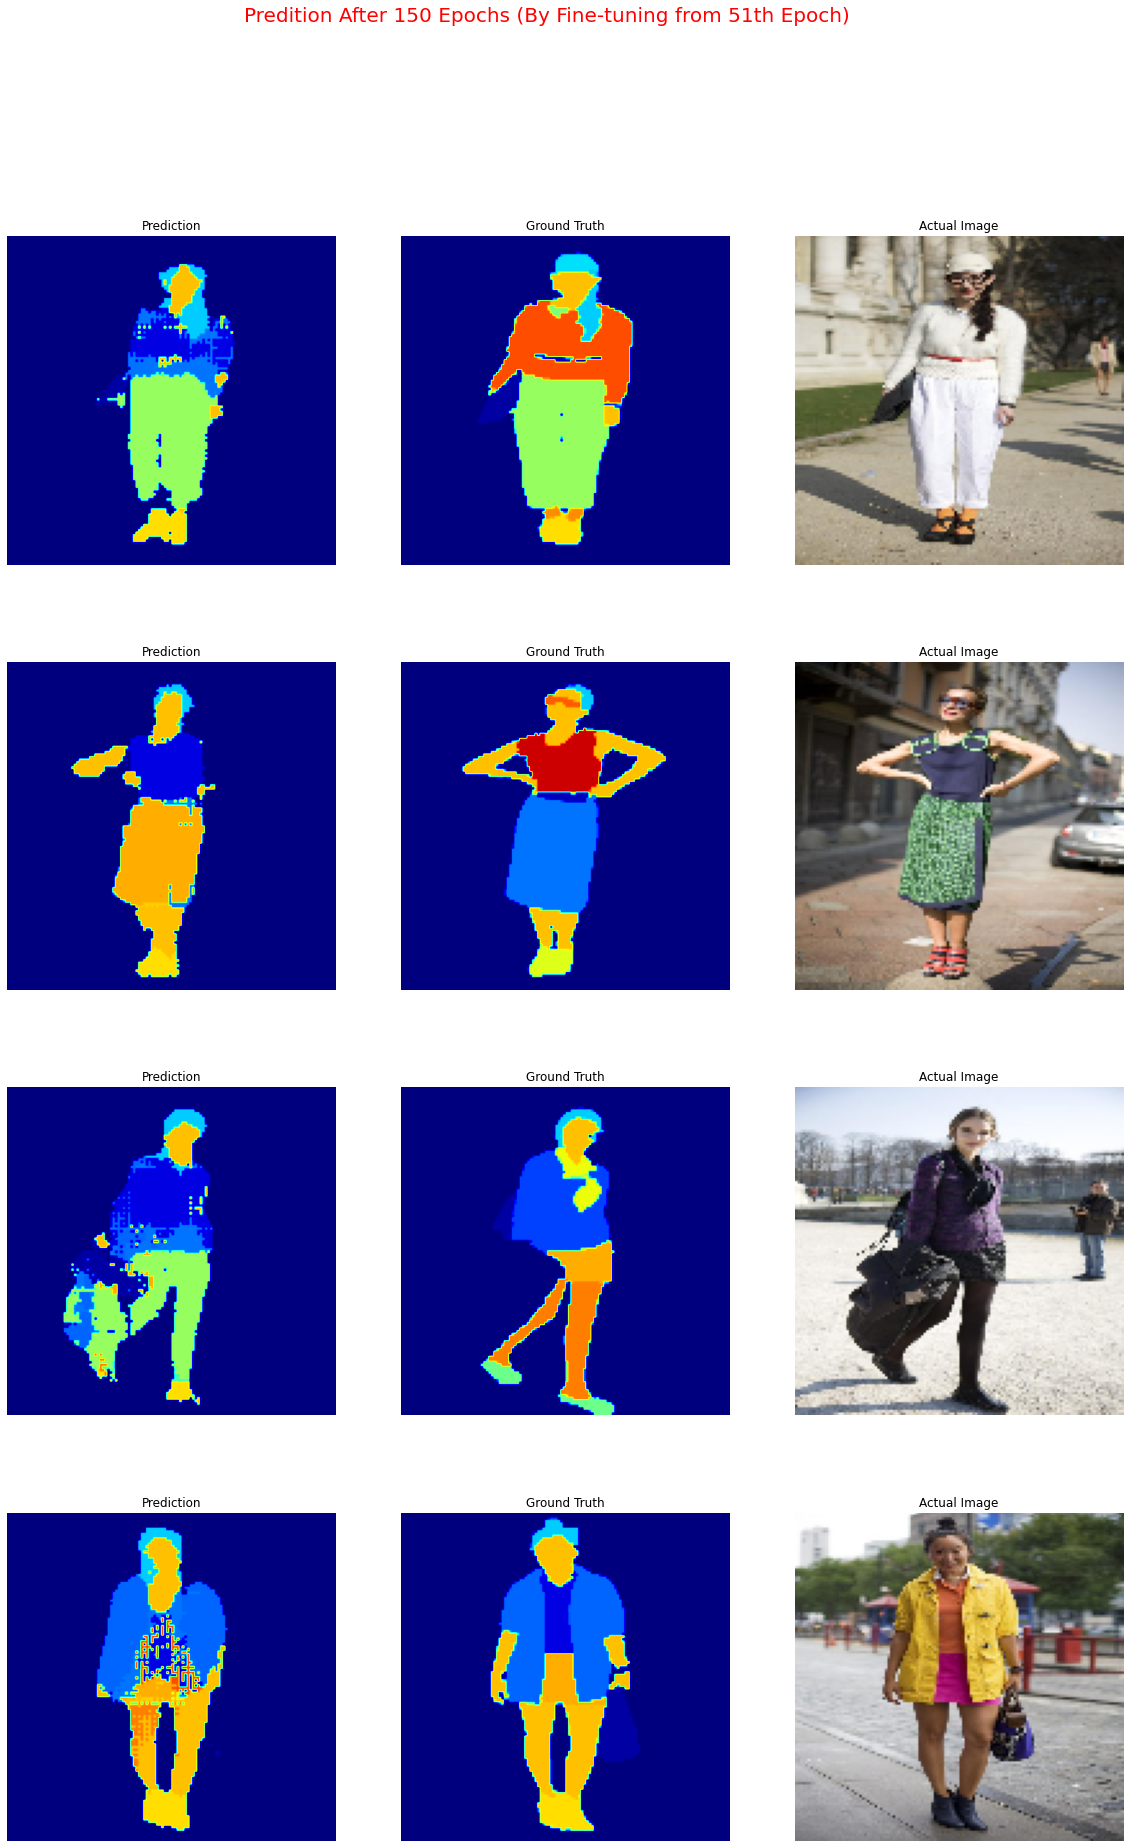

In [40]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 150 Epochs (By Fine-tuning from 51th Epoch)', color='red', size=20)  
plt.show()

<b>The model has improved significantly

# Performance Curves

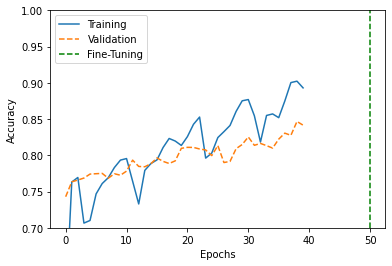

In [41]:
history_1 = hist_1.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']

history_2 = hist_2.history
acc.extend(history_2['accuracy'])
val_acc.extend(history_2['val_accuracy'])

plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.plot([50,50],[0.7,1.0], '--g', label='Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

<b>I couldnt get to 50 epochs due to limited computational power but with more epochs, hyperparameter tuning and training data, the model will surely perform better.